In [1]:
# https://www.tensorflow.org/official_models/fine_tuning_bert

In [2]:
!pip install -q tf-nightly
!pip install -q tf-models-nightly

### Import Libs

In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf

import tensorflow_hub as hub
import tensorflow_datasets as tfds
tfds.disable_progress_bar()

In [4]:
from official.modeling import tf_utils
from official import nlp
from official.nlp import bert

# Load the required submodules
import official.nlp.optimization
import official.nlp.bert.bert_models
import official.nlp.bert.configs
import official.nlp.bert.run_classifier
import official.nlp.bert.tokenization
import official.nlp.data.classifier_data_lib
import official.nlp.modeling.losses
import official.nlp.modeling.models
import official.nlp.modeling.networks

In [5]:
# This directory contains the configuration, vocabulary, and a pre-trained checkpoint used in this tutorial:
gs_folder_bert = "gs://cloud-tpu-checkpoints/bert/keras_bert/uncased_L-12_H-768_A-12"
tf.io.gfile.listdir(gs_folder_bert)

['bert_config.json',
 'bert_model.ckpt.data-00000-of-00001',
 'bert_model.ckpt.index',
 'vocab.txt']

In [6]:
#You can get a pre-trained BERT encoder from TensorFlow Hub here:
hub_url_bert = "https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2"

In [7]:
glue, info = tfds.load('glue/mrpc', with_info=True,
                       # It's small, load the whole dataset
                       batch_size=-1)

In [8]:
type(glue)

dict

In [9]:
glue.keys()

dict_keys(['test', 'train', 'validation'])

In [10]:
glue['train'].keys()

dict_keys(['idx', 'label', 'sentence1', 'sentence2'])

In [11]:
info.features

FeaturesDict({
    'idx': tf.int32,
    'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    'sentence1': Text(shape=(), dtype=tf.string),
    'sentence2': Text(shape=(), dtype=tf.string),
})

In [12]:
glue['train']['sentence1'][:5], glue['train']['sentence2'][:5]

(<tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'The identical rovers will act as robotic geologists , searching for evidence of past water .',
        b"Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is completed .",
        b'Spider-Man snatched $ 114.7 million in its debut last year and went on to capture $ 403.7 million .',
        b"The 2002 second quarter results don 't include figures from our friends at Compaq .",
        b'Solomon 5.5 is available initially in the United States and Canada , for a starting price of about $ 12,700 .'],
       dtype=object)>, <tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'The rovers act as robotic geologists , moving on six wheels .',
        b"Less than 20 percent of Boise 's sales would come from making lumber and paper after the OfficeMax purchase is complete , assuming those businesses aren 't sold .",
        b'Spider-Man , rated PG-13 , snatched $ 114.7 million in i

In [13]:
info.features['label'].names

['not_equivalent', 'equivalent']

In [14]:
glue_train = glue['train']

for key,value in glue_train.items():
  print(f"{key:9s}:{value[0].numpy()}")

idx      :1680
label    :0
sentence1:b'The identical rovers will act as robotic geologists , searching for evidence of past water .'
sentence2:b'The rovers act as robotic geologists , moving on six wheels .'


In [15]:
type(glue_train)

dict

### The BERT tokenizer
To fine tune a pre-trained model you need to be sure that you're using exactly the same tokenization, vocabulary, and index mapping as you used during training.

The BERT tokenizer used in this tutorial is written in pure Python (It's not built out of TensorFlow ops). So you can't just plug it into your model as a keras.layer like you can with preprocessing.TextVectorization.

The following code rebuilds the tokenizer that was used by the base model:

In [16]:
# Set up tokenizer to generate Tensorflow dataset
tokenizer = bert.tokenization.FullTokenizer(
    vocab_file = os.path.join(gs_folder_bert,'vocab.txt'),
    do_lower_case = True
)

In [17]:
tokens = tokenizer.tokenize("Hello world")
print(tokens)

ids = tokenizer.convert_tokens_to_ids(tokens)
print(ids)

['hello', 'world']
[7592, 2088]


In [18]:
len(tokenizer.vocab)

30522

In [19]:
tokenizer.inv_vocab[7000]      # inv_vocab gives dict int --> word

'licensed'

### Preprocess the data
The section manually preprocessed the dataset into the format expected by the model.

This dataset is small, so preprocessing can be done quickly and easily in memory. For larger datasets the tf_models library includes some tools for preprocessing and re-serializing a dataset. See Appendix: Re-encoding a large dataset for details.

#### Encode the sentences
The model expects its two inputs sentences to be concatenated together. This input is expected to start with a [CLS] "This is a classification problem" token, and each sentence should end with a [SEP] "Separator" token:

In [20]:
tokenizer.convert_tokens_to_ids(['[CLS]', '[SEP]'])

[101, 102]

In [21]:
# Start by encoding all the sentences while appending a [SEP] token, and packing them into ragged-tensors:

def encode_sentence(s):
  tokens = list(tokenizer.tokenize(s.numpy()))
  tokens.append('[SEP]')
  return tokenizer.convert_tokens_to_ids(tokens)

In [22]:
sentence1 = tf.ragged.constant([
      encode_sentence(s) for s in glue_train['sentence1']
])

sentence2 = tf.ragged.constant([
      encode_sentence(s) for s in glue_train['sentence2']
])

In [23]:
print("Sentence1 shape:", sentence1.shape.as_list())
print("Sentence2 shape:", sentence2.shape.as_list())

Sentence1 shape: [3668, None]
Sentence2 shape: [3668, None]


In [24]:
sentence1[0],sentence1[0].shape

(<tf.Tensor: shape=(18,), dtype=int32, numpy=
 array([ 1996,  7235,  9819,  2097,  2552,  2004, 20478, 21334,  2015,
         1010,  6575,  2005,  3350,  1997,  2627,  2300,  1012,   102],
       dtype=int32)>, TensorShape([18]))

In [25]:
sentence2[0],sentence2[0].shape


(<tf.Tensor: shape=(14,), dtype=int32, numpy=
 array([ 1996,  9819,  2552,  2004, 20478, 21334,  2015,  1010,  3048,
         2006,  2416,  7787,  1012,   102], dtype=int32)>, TensorShape([14]))

In [26]:
sentence1.shape[0]

3668

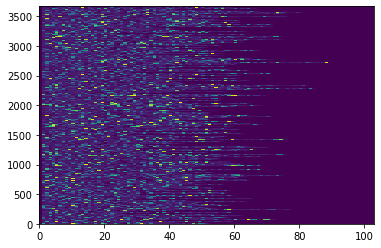

In [27]:
# Now prepend a [CLS] token, and concatenate the ragged tensors to form a single input_word_ids tensor for each example. 
# RaggedTensor.to_tensor() zero pads to the longest sequence.

cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]

input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)
_ = plt.pcolormesh(input_word_ids.to_tensor())

In [28]:
for i in input_word_ids:
  print(i)
  break

tf.Tensor(
[  101  1996  7235  9819  2097  2552  2004 20478 21334  2015  1010  6575
  2005  3350  1997  2627  2300  1012   102  1996  9819  2552  2004 20478
 21334  2015  1010  3048  2006  2416  7787  1012   102], shape=(33,), dtype=int32)


### Mask and input type
The model expects two additional inputs:

The input mask <br>
The input type <br>
The mask allows the model to cleanly differentiate between the content and the padding. The mask has the same shape as the input_word_ids, and contains a 1 anywhere the input_word_ids is not padding.

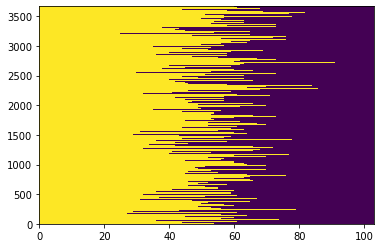

In [29]:
input_mask = tf.ones_like(input_word_ids).to_tensor()

plt.pcolormesh(input_mask)

In [30]:
print(input_mask.shape)
print(input_mask[0].shape)
print(input_mask[0])

(3668, 103)
(103,)
tf.Tensor(
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(103,), dtype=int32)


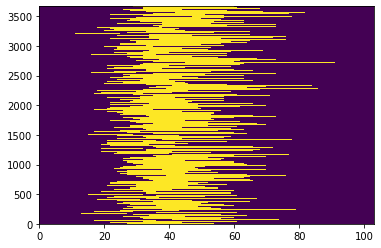

In [31]:
# The "input type" also has the same shape, but inside the non-padded region, contains a 0 or a 1 indicating which sentence the token is a part of.

type_cls = tf.zeros_like(cls)  
type_s1 = tf.zeros_like(sentence1)   # 0's will indicate input belongs to sentence 1
type_s2 = tf.ones_like(sentence2)    # 1's will indicate input belongs to sentence 1
input_type_ids = tf.concat([type_cls, type_s1, type_s2], axis=-1).to_tensor()

plt.pcolormesh(input_type_ids)

In [32]:
print(type_s1[0].shape)
print(type_s1[0])

print(type_s2[0].shape)
print(type_s2[0])

print(input_type_ids[0].shape)
print(input_type_ids[0])

(18,)
tf.Tensor([0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(18,), dtype=int32)
(14,)
tf.Tensor([1 1 1 1 1 1 1 1 1 1 1 1 1 1], shape=(14,), dtype=int32)
(103,)
tf.Tensor(
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0], shape=(103,), dtype=int32)


#### Put it all together

In [33]:
def encode_sentence(s, tokenizer):
   tokens = list(tokenizer.tokenize(s))
   tokens.append('[SEP]')
   return tokenizer.convert_tokens_to_ids(tokens)

def bert_encode(glue_dict, tokenizer):
  num_examples = len(glue_dict["sentence1"])
  
  sentence1 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
      for s in np.array(glue_dict["sentence1"])])
  sentence2 = tf.ragged.constant([
      encode_sentence(s, tokenizer)
       for s in np.array(glue_dict["sentence2"])])

  cls = [tokenizer.convert_tokens_to_ids(['[CLS]'])]*sentence1.shape[0]
  input_word_ids = tf.concat([cls, sentence1, sentence2], axis=-1)

  input_mask = tf.ones_like(input_word_ids).to_tensor()

  type_cls = tf.zeros_like(cls)
  type_s1 = tf.zeros_like(sentence1)
  type_s2 = tf.ones_like(sentence2)
  input_type_ids = tf.concat(
      [type_cls, type_s1, type_s2], axis=-1).to_tensor()

  inputs = {
      'input_word_ids': input_word_ids.to_tensor(),
      'input_mask': input_mask,
      'input_type_ids': input_type_ids}

  return inputs

In [34]:
glue_train = bert_encode(glue['train'], tokenizer)
glue_train_labels = glue['train']['label']

glue_validation = bert_encode(glue['validation'], tokenizer)
glue_validation_labels = glue['validation']['label']

glue_test = bert_encode(glue['test'], tokenizer)
glue_test_labels  = glue['test']['label']

Each subset of the data has been converted to a dictionary of features, and a set of labels. Each feature in the input dictionary has the same shape, and the number of labels should match:

In [35]:
for key, value in glue_train.items():
  print(f'{key:15s} shape: {value.shape}')

print(f'glue_train_labels shape: {glue_train_labels.shape}')

input_word_ids  shape: (3668, 103)
input_mask      shape: (3668, 103)
input_type_ids  shape: (3668, 103)
glue_train_labels shape: (3668,)


## The model
Build the model

The first step is to download the configuration for the pre-trained model.

In [36]:
import json

bert_config_file = os.path.join(gs_folder_bert, "bert_config.json")
config_dict = json.loads(tf.io.gfile.GFile(bert_config_file).read())

bert_config = bert.configs.BertConfig.from_dict(config_dict)

config_dict

{'attention_probs_dropout_prob': 0.1,
 'hidden_act': 'gelu',
 'hidden_dropout_prob': 0.1,
 'hidden_size': 768,
 'initializer_range': 0.02,
 'intermediate_size': 3072,
 'max_position_embeddings': 512,
 'num_attention_heads': 12,
 'num_hidden_layers': 12,
 'type_vocab_size': 2,
 'vocab_size': 30522}

The config defines the core BERT Model, which is a Keras model to predict the outputs of num_classes from the inputs with maximum sequence length max_seq_length.

This function returns both the encoder and the classifier.

In [37]:
bert_classifier, bert_encoder = bert.bert_models.classifier_model(bert_config,num_labels=2) 

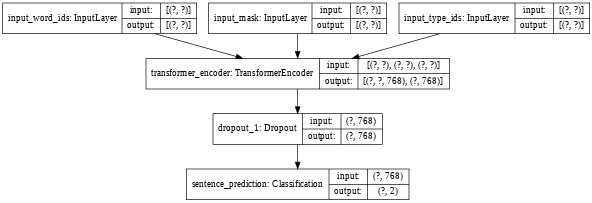

In [38]:
# The classifier has three inputs and one output:
tf.keras.utils.plot_model(bert_classifier, show_shapes=True, dpi=48)

In [39]:
# Run it on a test batch of data 10 examples from the training set. The output is the logits for the two classes:

glue_batch = {key: val[:10] for key, val in glue_train.items()}

bert_classifier(
    glue_batch, training=True
).numpy()

array([[-0.00749388,  0.32632828],
       [ 0.24785016,  0.30069244],
       [ 0.03166379,  0.40602654],
       [ 0.08911304,  0.39667144],
       [ 0.16322806,  0.55664414],
       [ 0.1795628 ,  0.49748254],
       [ 0.22760034,  0.4296386 ],
       [ 0.17387347,  0.09355759],
       [ 0.05524147,  0.23746894],
       [ 0.00634698,  0.3677263 ]], dtype=float32)

The TransformerEncoder in the center of the classifier above is the bert_encoder.

Inspecting the encoder, we see its stack of Transformer layers connected to those same three inputs:

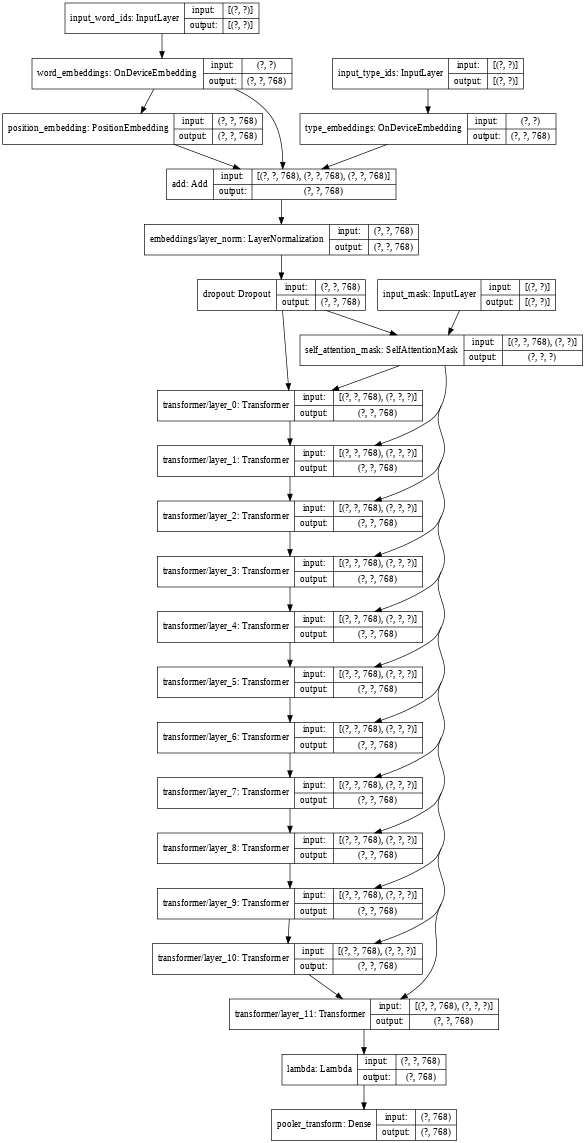

In [40]:
tf.keras.utils.plot_model(bert_encoder, show_shapes=True, dpi=48)

### Restore the encoder weights
When built the encoder is randomly initialized. Restore the encoder's weights from the checkpoint:

In [41]:
# Note: The pretrained TransformerEncoder is also available on TensorFlow Hub. See the Hub appendix for details.
checkpoint = tf.train.Checkpoint(model=bert_encoder)
checkpoint.restore(
    os.path.join(gs_folder_bert, 'bert_model.ckpt')).assert_consumed()

### Set up the optimizer
BERT adopts the Adam optimizer with weight decay (aka "AdamW"). It also employs a learning rate schedule that firstly warms up from 0 and then decays to 0.

In [42]:
# Set up epochs and steps
epochs = 3
batch_size = 32
eval_batch_size = 32

train_data_size = len(glue_train_labels)
steps_per_epoch = int(train_data_size / batch_size)
num_train_steps = steps_per_epoch * epochs
warmup_steps = int(epochs * train_data_size * 0.1 / batch_size)

# creates an optimizer with learning rate schedule
optimizer = nlp.optimization.create_optimizer(
    2e-5, num_train_steps=num_train_steps, num_warmup_steps=warmup_steps)

In [43]:
# This returns an AdamWeightDecay optimizer with the learning rate schedule set:
# To see an example of how to customize the optimizer and it's schedule, see the Optimizer schedule appendix.
type(optimizer)

official.nlp.optimization.AdamWeightDecay

### Train the model
The metric is accuracy and we use sparse categorical cross-entropy as loss.

In [44]:
metrics = [tf.keras.metrics.SparseCategoricalAccuracy('accuracy', dtype=tf.float32)]
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

bert_classifier.compile(
    optimizer=optimizer,
    loss=loss,
    metrics=metrics)

bert_classifier.fit(
      glue_train, glue_train_labels,
      validation_data=(glue_validation, glue_validation_labels),
      batch_size=32,
      epochs=epochs)

Epoch 1/3
115/115 [==============================] - 4052s 35s/step - loss: 0.6404 - accuracy: 0.6339 - val_loss: 0.4842 - val_accuracy: 0.7892
Epoch 2/3
115/115 [==============================] - 4052s 35s/step - loss: 0.4392 - accuracy: 0.7936 - val_loss: 0.3851 - val_accuracy: 0.8456
Epoch 3/3
115/115 [==============================] - 4062s 35s/step - loss: 0.2949 - accuracy: 0.8822 - val_loss: 0.3654 - val_accuracy: 0.8554


Now run the fine-tuned model on a custom example to see that it works.

Start by encoding some sentence pairs:

In [45]:
my_examples = bert_encode(
    glue_dict = {
        'sentence1':[
            'The rain in Spain falls mainly on the plain.',
            'Look I fine tuned BERT.'],
        'sentence2':[
            'It mostly rains on the flat lands of Spain.',
            'Is it working? This does not match.']
    },
    tokenizer=tokenizer)

In [46]:
# The model should report class 1 "match" for the first example and class 0 "no-match" for the second:
result = bert_classifier(my_examples, training=False)

result = tf.argmax(result).numpy()
result

array([1, 0])

In [47]:
np.array(info.features['label'].names)[result]

array(['equivalent', 'not_equivalent'], dtype='<U14')

In [50]:
print(np.array(info.features['label'].names))
print(info.features['label'].names)


['not_equivalent' 'equivalent']
['not_equivalent', 'equivalent']


### Save the model
Often the goal of training a model is to use it for something, so export the model and then restore it to be sure that it works.

In [48]:
export_dir='./saved_model'
tf.saved_model.save(bert_classifier, export_dir=export_dir)

Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.


INFO:tensorflow:Assets written to: ./saved_model/assets


INFO:tensorflow:Assets written to: ./saved_model/assets


In [49]:
reloaded = tf.saved_model.load(export_dir)
reloaded_result = reloaded([my_examples['input_word_ids'],
                            my_examples['input_mask'],
                            my_examples['input_type_ids']], training=False)

original_result = bert_classifier(my_examples, training=False)

# The results are (nearly) identical:
print(original_result.numpy())
print()
print(reloaded_result.numpy())

[[-1.0462171   1.57549   ]
 [ 0.3167791  -0.71325094]]

[[-1.0462166   1.5754893 ]
 [ 0.31677905 -0.71325094]]
